# **Vehicle Detection and Tracking** 
***
Let's start by recalling the main goals of this project: :

*   Perform a Histogram of Oriented Gradients (HOG) feature extraction on a labeled training set 
    of images and train a classifier
*   Optionally, you can also apply a color transform and append binned color features, as well as
    histograms of color, to your HOG feature vector.
*   Implement a sliding-window technique
*   use the trained classifier to search for vehicles in images
*   Run the pipeline on a video stream
*   create a heat map of recurring detections frame by frame to reject outliers
*   Estimate a bounding box for vehicles detected.


To do so the following point must be taken into consideration:
    1. decide what features should be used for the identification
        a. color features (histograms)
        b. spatial features
        c. HOG features
    2. Choose and train a suitable classifier
    3. use sliding window technique to search for vehicles in images
    4. implement a dropout for multiple detections at or near the same point
    5. implement a false positiv rejection
    6. implement a pipeline for video stream


In [23]:
# importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
import pickle
import glob
import time
import os
import random
import pandas as pd
from collections import deque
from sklearn.metrics import mean_absolute_error
from mpl_toolkits.mplot3d import Axes3D
from skimage.feature import hog
from sklearn.preprocessing import StandardScaler
import sklearn.svm as svm
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import AdaBoostClassifier, BaggingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from scipy.ndimage.measurements import label
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.svm import LinearSVC
from sklearn.metrics import confusion_matrix
%matplotlib inline

## Some useful functions

### function to load camera calibration matrix and function to undistort the images
(from last project)

In [4]:
# load the camera matrix and distortion coefficient
def camera_matrix():
    dist_pickle = pickle.load( open( "calibration_camera/camera_cal_pickle.p", "rb" ) )
    mtx = dist_pickle["mtx"]
    dist = dist_pickle["dist"]
    return mtx, dist

def cal_undistort(img, mtx, dist):
    undist = cv2.undistort(img, mtx, dist, None, mtx)  
    return undist

### function to draw rectangles on images

This function draw_boxes will be used later to draw bounding rectangles around identified vehicles in images.


In [5]:
def draw_boxes(img, bboxes, color=(0, 255, 0), thick=4):
    # make a copy of the image
    draw_img = np.copy(img)
    # draw each bounding box on your image copy using cv2.rectangle()
    for bbox in bboxes:
        cv2.rectangle(draw_img, bbox[0], bbox[1], color, thick)
    # return the image copy with boxes drawn
    return draw_img # Change this line to return image copy with boxes

# Feature maps for classifier

## Color  / Spatial / HOG features

In [6]:
def convert_color(img, conv='RGB2YCrCb'):
    if conv == 'RGB2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    if conv == 'BGR2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
    if conv == 'RGB2LUV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
    if conv == 'RGB2HSV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2HSV) 
    if conv == 'RGB2HLS':
        return cv2.cvtColor(img, cv2.COLOR_RGB2HLS) 
    if conv == 'RGB2YUV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2YUV) 

    
# Define a function to compute binned color features     
def bin_spatial(img, size=(32, 32)):
    # Use cv2.resize().ravel() to create the feature vector
    color1 = cv2.resize(img[:,:,0], size).ravel()
    color2 = cv2.resize(img[:,:,1], size).ravel()
    color3 = cv2.resize(img[:,:,2], size).ravel()
    # Return the feature vector
    return np.hstack((color1, color2, color3))


# Define a function to compute color histogram features  
def color_hist(img, nbins=32, bins_range=(0, 256)):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

# Define a function to return HOG features and visualization
def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        hog_calc='skimage', vis=False, feature_vec=True):
    if hog_calc == 'skimage':
        # Call with two outputs if vis==True
        if vis == True:
            features, hog_image = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                                      cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=True, 
                                      visualise=vis, feature_vector=feature_vec)
            return features, hog_image
        # Otherwise call with one output
        else:      
            features = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                           cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=True, 
                           visualise=vis, feature_vector=feature_vec)
            return features
    elif hog_calc == 'opencv':
        winSize = (64,64)
        blockSize = (16,16)
        blockStride = (8,8)
        cellSize = (8,8)
        nbins = 9

        derivAperture = 1
        winSigma = 4.
        histogramNormType = 0
        L2HysThreshold = 2.0000000000000001e-01
        gammaCorrection = 0
        nlevels = 64

        hog_opcv = cv2.HOGDescriptor(winSize,blockSize,blockStride,cellSize,nbins,derivAperture,winSigma,
                                histogramNormType,L2HysThreshold,gammaCorrection,nlevels)
        #compute(img[, winStride[, padding[, locations]]]) -> descriptors
        winStride = (8,8)
        padding = (8,8)
        locations = ((10,20),)
        hog_features = hog_opcv.compute(image,winStride,padding,locations)

        return hog_features

## Extraction of Color  / Spatial / HOG features for image(s)

In [7]:
# Define a function to extract features from a list of images
# Have this function call bin_spatial() and color_hist()
def extract_features(imgs, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True, hog_calc='skimage'):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        file_features = []
        # Read in each one by one
#        image = mpimg.imread(file)# for jpg,    png file 0-1, jpg file 0-255
        image = cv2.imread(file)# for png,    png file 0-255
        # apply color conversion if other than 'RGB'
        if color_space != 'RGB':
            if color_space == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif color_space == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif color_space == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif color_space == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif color_space == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else: feature_image = np.copy(image) 
            
        # Apply bin_spatial()
        if spatial_feat == True:
            spatial_features = bin_spatial(feature_image, size=spatial_size)
            file_features.append(spatial_features)
        # Apply color_hist()
        if hist_feat == True:
            hist_features = color_hist(feature_image, nbins=hist_bins)
            file_features.append(hist_features)
        # Call get_hog_features() with vis=False, feature_vec=True
        if hog_feat == True:
            if hog_channel == 'ALL':
                hog_features = []
                for channel in range(feature_image.shape[2]):
                    hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                        orient, pix_per_cell, cell_per_block, 
                                        hog_calc, vis=False, feature_vec=True))
                hog_features = np.ravel(hog_features)        
            else:
                hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                            pix_per_cell, cell_per_block, hog_calc, vis=False, feature_vec=True)
            # Append the new feature vector to the features list
            file_features.append(hog_features)
        features.append(np.concatenate(file_features))
    # Return list of feature vectors
    return features

# Training different classifier

In [8]:
train_clf = False
if train_clf == True:
# Read in cars and notcars

    data_set = '../data_base_png/*.png'
    images = glob.glob(data_set)
    cars = []
    notcars = []
    for image in images:
        if 'image' in image or 'extra' in image:
            notcars.append(image)
        else:
            cars.append(image)

    print('notcars: ', len(notcars))
    print('cars: ', len(cars))
    
    color_space = 'YCrCb' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
    orient = 12 # 18  # HOG orientations
    pix_per_cell = 8 # 5 # HOG pixels per cell
    cell_per_block = 2 # HOG cells per block
    hog_channel = "ALL" # Can be 0, 1, 2, or "ALL"
    spatial_size = (32,32) #(4, 4) # Spatial binning dimensions
    hist_bins = 64 #256    # Number of histogram bins
    spatial_feat = True # Spatial features on or off
    hist_feat = True # Histogram features on or off
    hog_feat = True # HOG features on or off

    car_features = extract_features(cars, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)
    notcar_features = extract_features(notcars, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)

    X = np.vstack((car_features, notcar_features)).astype(np.float64)                        
    # Fit a per-column scaler
    X_scaler = StandardScaler().fit(X)
    # Apply the scaler to X
    scaled_X = X_scaler.transform(X)

    # Define the labels vector
    y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))

    # Split up data into randomized training and test sets
    rand_state = np.random.randint(0, 100)
    X_train, X_test, y_train, y_test = train_test_split(
        scaled_X, y, test_size=0.2, random_state=rand_state)
    
    print('Using:',orient,'orientations',pix_per_cell,
            'pixels per cell and', cell_per_block,'cells per block')
    print('Feature vector length:', len(X_train[0]))

    for m in range(2,3):

        if m ==0:
            classifier_ = "LogisticRegression"
            clf = LogisticRegression()
            parameters = {'C':[0.01,0.1,1.], 'max_iter': [1,10,100,]}
    #        parameters = {'C':[0.01,0.1,1.,10.], 'max_iter': [10,100,1000,10000]}


        if m ==1:
            classifier_ = "MLPClassifier" 
    #### default: activation='relu', solver='adam', batch_size='auto',shuffle=True,
            clf = MLPClassifier(early_stopping=True, validation_fraction=0.1)
            parameters = {'hidden_layer_sizes':[(100, ),(150, )], 'max_iter': [100,200], \
                        'learning_rate_init':[0.001, 0.01] }
    #        parameters = {'hidden_layer_sizes':[(50, ),(100, ),(150, )], 'max_iter': [50,100,200,300], \
    #                    'learning_rate_init':[0.0005,  0.001, 0.01, 0.1] }

        if m ==2:
            classifier_ = "LinearSVC"
            clf = svm.LinearSVC()
            parameters = {'C':[0.01, 0.1,1.0], 'max_iter': [1,10,100]}
    #        parameters = {'C':[0.01,0.1,1.,10.], 'max_iter': [10,100,1000,10000]}        


        if m ==3:
            classifier_ = "SVC"
            clf = svm.SVC()
            parameters = {'kernel':['linear', 'rbf'], 'C':[0.01,0.1,1.,10.], 'gamma': [0.01, 0.1,10]}


    #classifier_ = "AdaBoostClassifier"
    #clf_gd = AdaBoostClassifier(DecisionTreeClassifier(max_depth=1),algorithm='SAMME',n_estimators=200) 

    #classifier_ = "BaggingClassifier"
    #clf_gd = BaggingClassifier(DecisionTreeClassifier(max_depth=1), n_estimators=200,n_jobs=-1)

        clf_gd = GridSearchCV(clf, parameters, return_train_score=True)

        # Check the training time for the SCLF
        print('\n\nClassifier: ', classifier_)
        t=time.time()
        clf_gd.fit(X_train, y_train)
        t2 = time.time()
        print(round(t2-t, 2), 'Seconds to train CLF...')
        # Check the score of the SVC
        print('Test Accuracy of CLF =  ', round(clf_gd.score(X_test, y_test), 5))
        # Check the prediction time for a single sample
        t=time.time()

        # Check the prediction time for a single sample
        t=round(time.time(),10)
        prediction = clf_gd.predict(X_test[0].reshape(1, -1))
        t2 = round(time.time(),10)
        print(round(t2-t,10), 'Seconds to predict with ', classifier_)    

        best_param_dict = clf_gd.best_params_ 
        grid_result = clf_gd.cv_results_

        print('best_param_dict: ')
        print(best_param_dict)
        print('\ngrid_result')
        res = pd.DataFrame(data=grid_result)
        print(res)
        print('End ',classifier_,'\n\n')

# Training selected classifier with different feature parameter

In [9]:
train = False
neg_mining = False
if train == True:
    # Read in cars and notcars
    data_set = 'data_base_png/*.png'
    images = glob.glob(data_set)
    cars = []
    notcars = []
    for image in images:
        if 'image' in image or 'extra' in image:
            notcars.append(image)
        else:
            cars.append(image)

    print('notcars: ', len(notcars))
    print('cars: ', len(cars))
 
    color_space = 'YCrCb' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
    orient = 18 # HOG orientations
    pix_per_cell = 8 # HOG pixels per cell
    cell_per_block = 2 # HOG cells per block
    hog_channel = "ALL" # Can be 0, 1, 2, or "ALL"
    spatial_size = (4,4)  # Spatial binning dimensions
    hist_bins = 256 # Number of histogram bins
    spatial_feat = True # Spatial features on or off
    hist_feat = True # Histogram features on or off
    hog_feat = True # HOG features on or off
    hog_calc = "skimage" #  "skimage" or "opencv"
    
    car_features = extract_features(cars, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)
    notcar_features = extract_features(notcars, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)

    X = np.vstack((car_features, notcar_features)).astype(np.float64)                        
    # Fit a per-column scaler
    X_scaler = StandardScaler().fit(X)
    # Apply the scaler to X
    scaled_X = X_scaler.transform(X)

    # Define the labels vector
    y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))


    # Split up data into randomized training and test sets
    rand_state = np.random.randint(0, 100)
    X_train, X_test, y_train, y_test = train_test_split(
        scaled_X, y, test_size=0.2, random_state=rand_state)

    print('Using:',orient,'orientations',pix_per_cell,
        'pixels per cell and', cell_per_block,'cells per block')
    print('Feature vector length:', len(X_train[0]))

###### Try different clfs
    for m in range(3,4):
        if m ==0:
            classifier_ = "LogisticRegression"
            clf = LogisticRegression(C = 1.,max_iter = 10 )
        if m ==1:
            classifier_ = "MLPClassifier" 
            clf = MLPClassifier(hidden_layer_sizes=100,max_iter=100, learning_rate_init=0.01, \
                                early_stopping=True, validation_fraction=0.1)
        if m ==2:
            classifier_ = "SVC"
            clf = svm.SVC(kernel="linear", gamma = 0.1, C = 0.1, probability=False)
        if m ==3:
            classifier_ = "LinearSVC"
            clf = svm.LinearSVC(C = 0.1,max_iter = 10)
        if m ==4:
            classifier_ = "SVC"
            clf = svm.SVC(kernel="linear", gamma = 0.1, C = 0.1, probability=False)
    
        # Check the training time for the CLF
        print('\n\nClassifier: ', classifier_)
        t=time.time()
        clf.fit(X_train, y_train)
        t2 = time.time()
        print(round(t2-t, 2), 'Seconds to train ...', classifier_)
        # Check the score of the CLF
    #    print('Train Accuracy of CLF = ', round(svc.score(X_train, y_train),5))
        t=time.time()    
        print('Test Accuracy of ',classifier_,' =  ', round(clf.score(X_test, y_test), 5))
        t2 = time.time()
        print(round(t2-t,10), 'Seconds to score with ', classifier_) 

        # Check the prediction time for a single sample
        t=round(time.time(),10)
        prediction = clf.predict(X_test[0].reshape(1, -1))
        t2 = round(time.time(),10)
        print(round(t2-t,10), 'Seconds to predict with ', classifier_)    

        # Visualize a confusion matrix of the predictions from the CLF
        pred = clf.predict(X_test)
        cm = pd.DataFrame(confusion_matrix(pred, y_test))
        print(cm)    

    ################# hard neg mining ########################     
        if neg_mining :
            neg_cars = []
            neg_notcars = []

            k = 0
            for p in pred:
                if p == 1 and y_test[k]==0:
                    neg_notcars.append(X_test[k])
                if p == 0 and y_test[k]==1:
                    neg_cars.append(X_test[k])
                k +=1
            #############################

            neg_notcars = np.array(neg_notcars).reshape(len(neg_notcars), -1)

            # Split up data into randomized training and test sets
            rand_state = np.random.randint(0, 100)
            X_train, X_test, y_train, y_test = train_test_split(
                scaled_X, y, test_size=0.2, random_state=rand_state)
                                             
            X_train_neg = np.vstack(( neg_notcars, X_train)).astype(np.float64)                                               

            # Define the labels vector
            y_train_neg = np.hstack((np.zeros(len(neg_notcars)), y_train))

            # Check the training time for the CLF
            t=time.time()
            clf.fit(X_train_neg, y_train_neg)
            t2 = time.time()
            print(round(t2-t, 2), 'Seconds to train ...', classifier_)
            # Check the score of the CLF
            t=time.time()
            print('\n Hard negativ mining \n Test Accuracy of ',classifier_,' =  ', round(clf.score(X_test, y_test), 5)) 
            t2 = time.time()
            print(round(t2-t, 2), 'Seconds to score ...', classifier_)       
            
            # Visualize a confusion matrix of the predictions from the CLF
            pred = clf.predict(X_test)
            cm = pd.DataFrame(confusion_matrix(pred, y_test))
            print(cm)
            
            X_train_neg = []
    #########################################################################################

        cell_per_win = 8

        dist_pickle = {}
        dist_pickle["svc"] = clf
        dist_pickle["clf_name"] = classifier_
        dist_pickle["scaler"] = X_scaler
        dist_pickle["color_space"] = color_space
        dist_pickle["orient"] = orient # HOG orientations
        dist_pickle["pix_per_cell"] = pix_per_cell # HOG pixels per cell
        dist_pickle["cell_per_block"] = cell_per_block # HOG cells per block
        dist_pickle["hog_channel"] = hog_channel # Can be 0, 1, 2, or "ALL"
        dist_pickle["hog_calc"] = hog_calc       
        dist_pickle["spatial_size"] = spatial_size # Spatial binning dimensions
        dist_pickle["hist_bins"] = hist_bins # Number of histogram bins
        dist_pickle["cell_per_win"] = cell_per_win
        dist_pickle["data_set"] = data_set
        pickle_name = "SVC_trained/" +classifier_ +time.strftime(("_%Y%m%d_%H%M%S"))+ ".p"
        pickle.dump( dist_pickle, open( pickle_name, "wb" ) ) 
        print('\n color_space: ', color_space, 'orient: ', orient, 'pix_per_cell: ', pix_per_cell,'cell_per_block: ', cell_per_block,\
              'hog_channel: ', hog_channel,'\n spatial_size: ', 'hog_calc :', hog_calc, spatial_size,'hist_bins: ', hist_bins, \
             'data_set: ', data_set, '\n save file: ', pickle_name)

# Sliding Window Implementation

In [10]:
def mul_win_slide(img,svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins, cell_per_win, hog_calc):

    xbox_left_all = []
    ytop_draw_all = []
    win_draw_all = []
    ystart_all = []
    bboxes_raw = []
    xbox_left_all = []
    ytop_draw_all = []
    win_draw_all = []
    ystart_all = []
    bboxes_raw = []
    
    cells_per_step = 2
    img_ =  np.copy(img)
    
    for scale in range(1,4):

        if scale == 4:
            ystop = 680
            steps = 0
            ystart = int((ystop-pix_per_cell*(cell_per_win+steps*cells_per_step)*scale))
        if scale == 3:
            ystop = 630
            steps = 0
            ystart = int((ystop-pix_per_cell*(cell_per_win+steps*cells_per_step)*scale))
        if scale == 2:
            ystop = 560
            steps = 1
            ystart = int((ystop-pix_per_cell*(cell_per_win+steps*cells_per_step)*scale))
        if scale == 1:
            ystop = 500
            steps = 3
            ystart = int((ystop-pix_per_cell*(cell_per_win+steps*cells_per_step)*scale))      

        xbox_left,ytop_draw, win_draw, ystart_ar = find_cars(img, ystart, ystop, scale, svc, X_scaler, \
                                                             orient, pix_per_cell, cell_per_block, spatial_size, \
                                                             hist_bins, hog_calc)
        xbox_left_all = np.concatenate((xbox_left_all, xbox_left)).flatten().astype(np.int)
        ytop_draw_all = np.concatenate((ytop_draw_all, ytop_draw)).flatten().astype(np.int)
        win_draw_all = np.concatenate((win_draw_all, win_draw)).flatten().astype(np.int) 
        ystart_all = np.concatenate((ystart_all, ystart_ar)).flatten().astype(np.int) 

    for i in range(len(xbox_left_all)):
        if i == 0:      
            bboxes_raw =np.int32([[xbox_left_all[i], ytop_draw_all[i]+ystart_all[i],\
                                  xbox_left_all[i]+win_draw_all[i],ytop_draw_all[i]+win_draw_all[i]+ystart_all[i]]])
        else:
            bboxes_raw= np.concatenate((bboxes_raw, np.int32([[xbox_left_all[i], ytop_draw_all[i]+ystart_all[i],\
                                  xbox_left_all[i]+win_draw_all[i],ytop_draw_all[i]+win_draw_all[i]+ystart_all[i]]])), axis =0)
    return bboxes_raw

# Finding vehicles in a defined window

In [11]:
# Define a single function that can extract features using hog sub-sampling and make predictions
def find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins, hog_calc):

    draw_img = np.copy(img)

    # crop image to the search area
    img_tosearch = draw_img[ystart:ystop,:,:]
    ctrans_tosearch = convert_color(img_tosearch, conv='RGB2YCrCb') #conv='RGB2YCrCb') conv='RGB2HSV')
    # apply scaling with resizing the image
    if scale != 1:
        imshape = ctrans_tosearch.shape       
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))    
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]
    
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, hog_calc, feature_vec=False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, hog_calc, feature_vec=False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, hog_calc, feature_vec=False)
    
    # Define blocks and steps
    nxblocks = (ch1.shape[1] // pix_per_cell)-1
    nyblocks = (ch1.shape[0] // pix_per_cell)-1 
    nfeat_per_block = orient*cell_per_block**2
   
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64 #64
    nblocks_per_window = (window // pix_per_cell)-1 
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step
    
    xbox_left = []
    ytop_draw = []
    win_draw = []
    ystart_ar = []
    
    # only use the streetside we are driving on
    if scale == 5:
        xrange_lh = int(60/scale)
        xrange_rh = int(1280/scale)        
    elif  scale == 4:
        xrange_lh = int(10/scale)
        xrange_rh = int(1280 /scale)
    elif  scale == 3:
        xrange_lh = int(120/scale)
        xrange_rh = int(1280/scale)       
    elif  scale == 2:
        xrange_lh = int(260/scale)
        xrange_rh = int(1280/scale)
    elif  scale == 1:
        xrange_lh = int(350/scale)
        xrange_rh = int(1200/scale)

    # loop over all windows
    for yb  in range(nysteps+1):#,0,-1):
        for xb in range(nxsteps+1):#,0,-1):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_features = np.concatenate((hog_feat1, hog_feat2, hog_feat3)).flatten()           

            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell
            # Extract the image patch only in the predefined area
            if (xleft >= xrange_lh) & ((xleft+window)<= xrange_rh):
                subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))          
                # Get spatial features
                spatial_features = bin_spatial(subimg, size=spatial_size)
                # Get color features
                hist_features = color_hist(subimg, nbins=hist_bins)
                # Scale features and make a prediction
                test_features = X_scaler.transform(np.hstack((spatial_features, hist_features, \
                                                              hog_features)).reshape(1, -1))
                classifier_ = ''
                if classifier_ =='MLPClassifier':
                    test_prediction = svc.predict(test_features)
                    if test_prediction == 1:
                        print('test_prediction: ', test_prediction)
                        xbox_left.append(np.int(xleft*scale))
                        ytop_draw.append(np.int(ytop*scale))
                        win_draw.append(np.int(window*scale))
                        ystart_ar.append(ystart)
                else:
                    test_proba = svc.decision_function(test_features)
                    if test_proba > clf_svc.threshold_proba:
#                    if test_proba > -0.35:
                        xbox_left.append(np.int(xleft*scale))
                        ytop_draw.append(np.int(ytop*scale))
                        win_draw.append(np.int(window*scale))
                        ystart_ar.append(ystart)
                
    return xbox_left,ytop_draw, win_draw, ystart_ar

# Remove multiple detections with non-max suppression

In [12]:
#http://www.pyimagesearch.com/2015/02/16/faster-non-maximum-suppression-python/

# Malisiewicz et al.
def non_max_suppression_fast(boxes, overlapThresh):
    # if there are no boxes, return an empty list
    if len(boxes) == 0:
        return []
 
    # if the bounding boxes integers, convert them to floats --
    # this is important since we'll be doing a bunch of divisions
    if boxes.dtype.kind == "i":
        boxes = boxes.astype("float")
 
    # initialize the list of picked indexes	
    pick = []
 
    # grab the coordinates of the bounding boxes
    x1 = boxes[:,0]
    y1 = boxes[:,1]
    x2 = boxes[:,2]
    y2 = boxes[:,3]
 
    # compute the area of the bounding boxes and sort the bounding
    # boxes by the bottom-right y-coordinate of the bounding box
    area = (x2 - x1 + 1) * (y2 - y1 + 1)
    idxs = np.argsort(y2)
 
    # keep looping while some indexes still remain in the indexes
    # list
    while len(idxs) > 0:
        # grab the last index in the indexes list and add the
        # index value to the list of picked indexes
        last = len(idxs) - 1
        i = idxs[last]
        pick.append(i)
 
        # find the largest (x, y) coordinates for the start of
        # the bounding box and the smallest (x, y) coordinates
        # for the end of the bounding box
        xx1 = np.maximum(x1[i], x1[idxs[:last]])
        yy1 = np.maximum(y1[i], y1[idxs[:last]])
        xx2 = np.minimum(x2[i], x2[idxs[:last]])
        yy2 = np.minimum(y2[i], y2[idxs[:last]])
 
        # compute the width and height of the bounding box
        w = np.maximum(0, xx2 - xx1 + 1)
        h = np.maximum(0, yy2 - yy1 + 1)
 
        # compute the ratio of overlap
        overlap = (w * h) / area[idxs[:last]]
 
        # delete all indexes from the index list that have
        idxs = np.delete(idxs, np.concatenate(([last],
            np.where(overlap > overlapThresh)[0])))
 
    # return only the bounding boxes that were picked using the
    # integer data type
    return boxes[pick].astype("int")

In [13]:
def area_overlap(rect1, rect2):
# calculates the overlap between two rectangular areas

    x1, y1, x2, y2 = rect1
    x3, y3, x4, y4 = rect2

    area = (x4 - x3 + 1) * (y4 - y3 + 1)

    xx1 = np.maximum(x1, x3)
    yy1 = np.maximum(y1, y3)
    xx2 = np.minimum(x2, x4)
    yy2 = np.minimum(y2, y4)

    # calculate the width and height common area
    w = np.maximum(0, xx2 - xx1 + 1)
    h = np.maximum(0, yy2 - yy1 + 1)

    # calculate the overlap-ratio 
    overlap = (w * h) / area
    return overlap


# Deal with Multiple detections / false positives 
# with use of a Heat map 

In [14]:
def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        heatmap[box[1]:box[3], box[0]:box[2]] += 1
    return heatmap# Return updated heatmap
    
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img

def labeled_bboxes(img, labels):
    # Iterate through all detected cars
    bboxes = []
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Append the box to an array
        bboxes.append(bbox)
    # Return the boxes
    return bboxes

# Picture pipeline


 save file:  SVC_trained/LinearSVC_20170421_173733.p 
 color_space:  YCrCb orient:  18 pix_per_cell:  8 cell_per_block:  2 hog_channel:  ALL hog_calc : skimage 
 spatial_size:  (4, 4) hist_bins:  256 clf_svc.cell_per_win:  8 
data_set:  data_base_png/*.png
test_images\test1.jpg
test_images\test3.jpg
test_images\test5.jpg


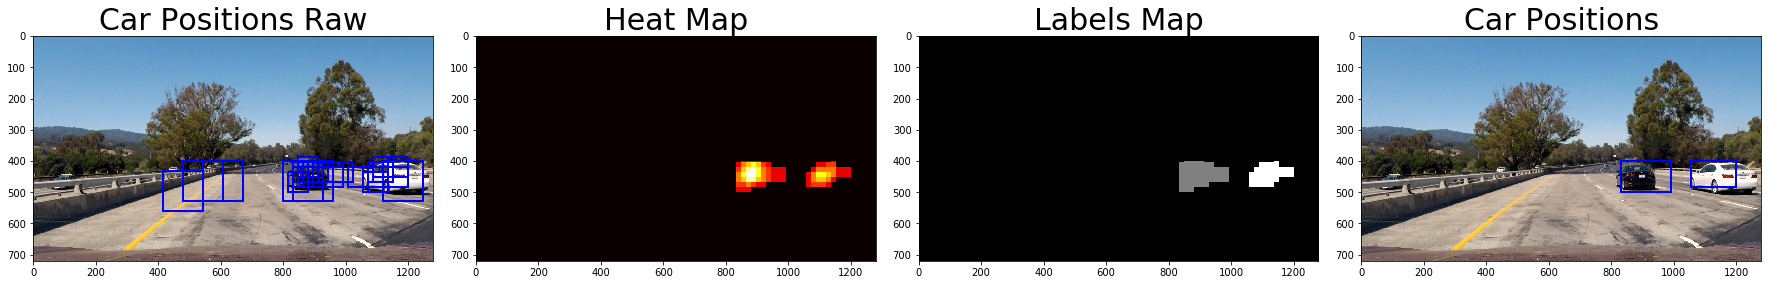

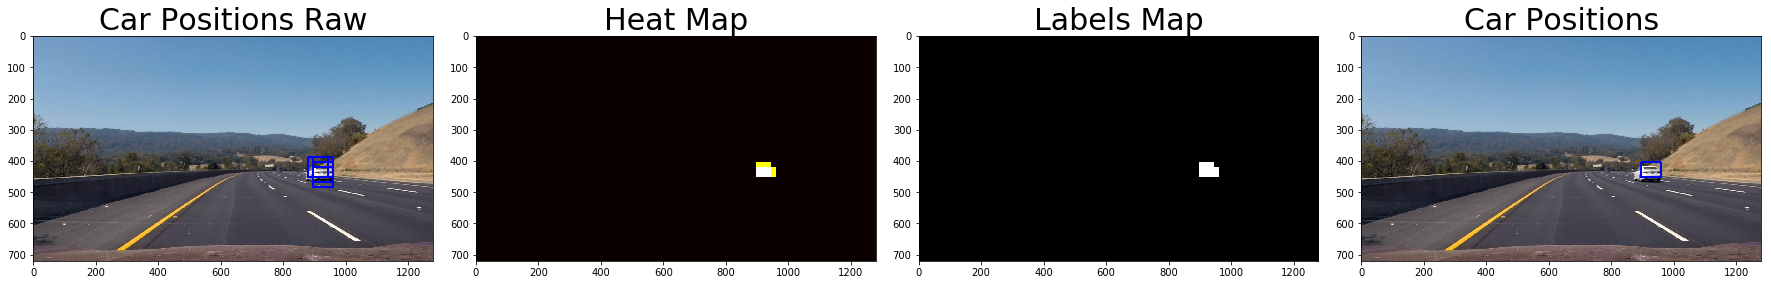

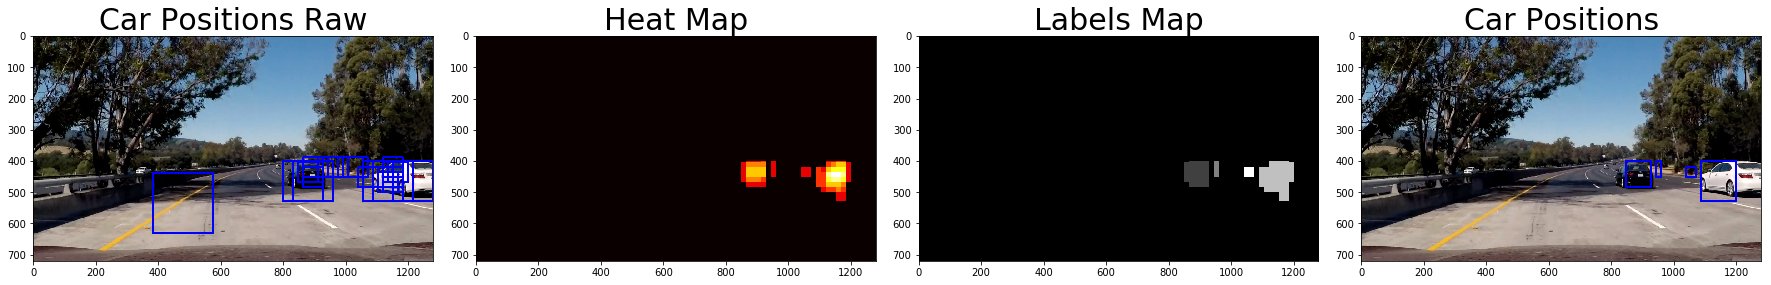

In [48]:
picture_pipe = True

if picture_pipe:
    debug = False


    # load the classifier and scaler
    pickle_name = "SVC_trained/LinearSVC_20170421_173733.p"
    dist_pickle = pickle.load( open(pickle_name, "rb" ) )
    svc = dist_pickle["svc"]
    X_scaler = dist_pickle["scaler"]
    classifier_ = dist_pickle["clf_name"]
    color_space = dist_pickle["color_space"]
    orient = dist_pickle["orient"]
    pix_per_cell = dist_pickle["pix_per_cell"]
    cell_per_block = dist_pickle["cell_per_block"]
    hog_channel = dist_pickle["hog_channel"]
    hog_calc = dist_pickle["hog_calc"]
    spatial_size = dist_pickle["spatial_size"]
    hist_bins = dist_pickle["hist_bins"]
    cell_per_win = dist_pickle["cell_per_win"]
    data_set = dist_pickle["data_set"]
        
    print('\n save file: ', pickle_name, '\n color_space: ', color_space, 'orient: ', orient, \
          'pix_per_cell: ', pix_per_cell,'cell_per_block: ', cell_per_block, \
          'hog_channel: ', hog_channel,'hog_calc :', hog_calc, '\n spatial_size: ', spatial_size,\
          'hist_bins: ', hist_bins, 'clf_svc.cell_per_win: ',cell_per_win,'\ndata_set: ', data_set)

    images = glob.glob('test_images/*.jpg')   
    for fname in images:
        # read in each image
        img =  mpimg.imread(fname)
        draw_img = np.copy(img)
        # Find cars with multiple window sizes
        car_boxes_raw = mul_win_slide(draw_img,svc, X_scaler, orient, pix_per_cell, cell_per_block, \
                                      spatial_size, hist_bins, cell_per_win, hog_calc)
        
        # Remove duplicates
        draw_img = np.copy(img)
        heat = np.zeros_like(draw_img[:,:,0]).astype(np.float)
        # Add heat to each box in box list
        heat = add_heat(heat,car_boxes_raw)
        # Apply threshold to help remove false positives
        heat = apply_threshold(heat,2)

        # Visualize the heatmap when displaying    
        heatmap = np.clip(heat, 0, 255)


            # Find final boxes from heatmap using label function
        labels = label(heatmap)
        draw_img = draw_labeled_bboxes(np.copy(img), labels)    
        bboxes_raw = []
        print(fname)
        
        if debug == True:
            image = np.copy(img)
            draw_img = debug_frame(image, draw_img, heatmap, heatmap, car_boxes_raw, heatmap)
            #draw_img = debug_frame(deb_image, draw_img, heat_combined, heat_combined_raw, car_boxes_raw, heatmap) 

        box_img = np.copy(img)
        for n in range(len(car_boxes_raw)):
            cv2.rectangle(box_img,(car_boxes_raw[n,0],car_boxes_raw[n,1]),(car_boxes_raw[n,2],car_boxes_raw[n,3]),(0,0,255),6)            
            

        f, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(24, 9))
        f.tight_layout()
        ax1.imshow(box_img, cmap='gray')
        ax1.set_title('Car Positions Raw', fontsize=30)
        ax2.imshow(heatmap, cmap='hot')
        ax2.set_title('Heat Map', fontsize=30)
        ax3.imshow(labels[0], cmap='gray')
        ax3.set_title('Labels Map', fontsize=30)
        ax4.imshow(draw_img, cmap='gray')
        ax4.set_title('Car Positions', fontsize=30)
        
        plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)  
    

# Video Pipeline

In [15]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [16]:
class car_boxes:
    def __init__(self):
        self.all_boxes = deque(maxlen=12)
        
        
class clf_dt:
    def __init__(self):
        self.svc = None
        self.X_scaler = None

        self.color_space = 'HSV'
        self.orient = 9
        self.pix_per_cell = 8
        self.cell_per_block = 2
        self.hog_channel = 'ALL'
        self.spatial_size = (32,32)
        self.hist_bins = 64
        self.cell_per_win = 8
        self.hog_calc = 'skimage'
        self.threshold_proba = 0.1


In [17]:
def process_frame(image, debug=False, heat_threshold = 1):
    global c_mtx
    global c_dist

    undist_img = cal_undistort(image, c_mtx, c_dist)
    # read in each image
    draw_img = np.copy(undist_img)
    # Find cars with multiple window sizes
    car_boxes_raw = mul_win_slide(draw_img,clf_svc.svc, clf_svc.X_scaler, clf_svc.orient,clf_svc.pix_per_cell, \
                                  clf_svc.cell_per_block, clf_svc.spatial_size, clf_svc.hist_bins, \
                                  clf_svc.cell_per_win,clf_svc.hog_calc)
    # Remove duplicates
    draw_img = np.copy(undist_img)
    heat = np.zeros_like(draw_img[:,:,0]).astype(np.float)
    # Add heat to each box in box list
    heat = add_heat(heat,car_boxes_raw)
    # Apply threshold to help remove false positives
    heat = apply_threshold(heat,heat_threshold)

    # Visualize the heatmap when displaying    
    heatmap = np.clip(heat, 0, 255)
    
    # Remove multiple detections => get boxes around vehicles
    labels = label(heatmap)
    bboxes = []
    bboxes = labeled_bboxes(draw_img, labels)
    # Append boxes to ring buffer
    car_bx.all_boxes.append(bboxes)   

    all_boxes = []
    box_comb = np.ravel(np.array(car_bx.all_boxes))
    # combine the boxes from current and previous frames
    for i in range(len(box_comb)):
        all_boxes.extend(np.ravel(box_comb[i]))
    new_boxes = []
    i = 0
    while i <= len(all_boxes)-3:
        new_boxes.append(all_boxes[i:i+4])
        i += 4
    # combine overlapping rectangles
    # more than 7 overlapping boxes
    end_bxes,w = cv2.groupRectangles(np.array(new_boxes).tolist(), 7,.1) # eps = 0.1

    for box in end_bxes:
        cv2.rectangle(draw_img, (box[0], box[1]), (box[2],box[3]), (0,255,0), 4)
    
    if debug == True:
        deb_image =  np.copy(undist_img)
        draw_img = debug_frame(deb_image, draw_img, heatmap, heatmap, car_boxes_raw, heatmap)        
    
    return draw_img

In [20]:
# Video loop over different clfs and parameters

pickle_set = [x for x in os.listdir('SVC_trained') if x.endswith('.p')]
for pickle_fn in pickle_set:
    pickle_name= 'SVC_trained\\'+ pickle_fn
    
    clf_svc = clf_dt()
    dist_pickle = pickle.load( open(pickle_name, "rb" ) )
    clf_svc.svc = dist_pickle["svc"]
    clf_svc.X_scaler = dist_pickle["scaler"]
    clf_svc.classifier_ = dist_pickle["clf_name"]
    clf_svc.color_space = dist_pickle["color_space"]
    clf_svc.orient = dist_pickle["orient"]
    clf_svc.pix_per_cell = dist_pickle["pix_per_cell"]
    clf_svc.cell_per_block = dist_pickle["cell_per_block"]
    clf_svc.hog_channel = dist_pickle["hog_channel"]
    clf_svc.hog_calc = dist_pickle["hog_calc"]
    clf_svc.spatial_size = dist_pickle["spatial_size"]
    clf_svc.hist_bins = dist_pickle["hist_bins"]
    clf_svc.cell_per_win = dist_pickle["cell_per_win"]
    data_set = dist_pickle["data_set"]
        
    print('\n save file: ', pickle_name, '\n color_space: ', clf_svc.color_space, 'orient: ', clf_svc.orient, \
          'pix_per_cell: ', clf_svc.pix_per_cell,'cell_per_block: ', clf_svc.cell_per_block, \
          'hog_channel: ', clf_svc.hog_channel,'hog_calc :', clf_svc.hog_calc, '\n spatial_size: ', clf_svc.spatial_size,\
          'hist_bins: ', clf_svc.hist_bins, 'clf_svc.cell_per_win: ',clf_svc.cell_per_win,'\ndata_set: ', data_set)

    car_bx = car_boxes()
    # Selection parameters.
    heat_thr = 2
    clf_svc.threshold_proba = -0.35
    
    c_mtx, c_dist = camera_matrix() #return mtx, dist
    
    prj_name = os.path.splitext(os.path.basename(pickle_name))[0]
    
    project_output = prj_name +"_pjc_vid_"+time.strftime(("_%Y%m%d_%H%M%S"))+ ".mp4"

    clip1 = VideoFileClip("project_video.mp4")
    #clip1 = VideoFileClip("project_video_cut_2.mp4")
    #clip1 = VideoFileClip("test_video.mp4")

    project_clip = clip1.fl_image(lambda x: process_frame(x, debug=False, heat_threshold=heat_thr))
    %time project_clip.write_videofile(project_output, audio=False)



 save file:  SVC_trained\LinearSVC_20170421_173733.p 
 color_space:  YCrCb orient:  18 pix_per_cell:  8 cell_per_block:  2 hog_channel:  ALL hog_calc : skimage 
 spatial_size:  (4, 4) hist_bins:  256 clf_svc.cell_per_win:  8 
data_set:  data_base_png/*.png
[MoviePy] >>>> Building video LinearSVC_20170421_173733_pjc_vid__20170423_113613.mp4
[MoviePy] Writing video LinearSVC_20170421_173733_pjc_vid__20170423_113613.mp4


100%|█████████▉| 1260/1261 [06:59<00:00,  2.98it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: LinearSVC_20170421_173733_pjc_vid__20170423_113613.mp4 

Wall time: 6min 59s


# References:
[1] Malisiewicz et al., "Faster Non-maximum Suppression in Python" http://www.pyimagesearch.com/2015/02/16/faster-non-maximum-suppression-python/

# Testing and debugging

notcars:  8968
cars:  8792


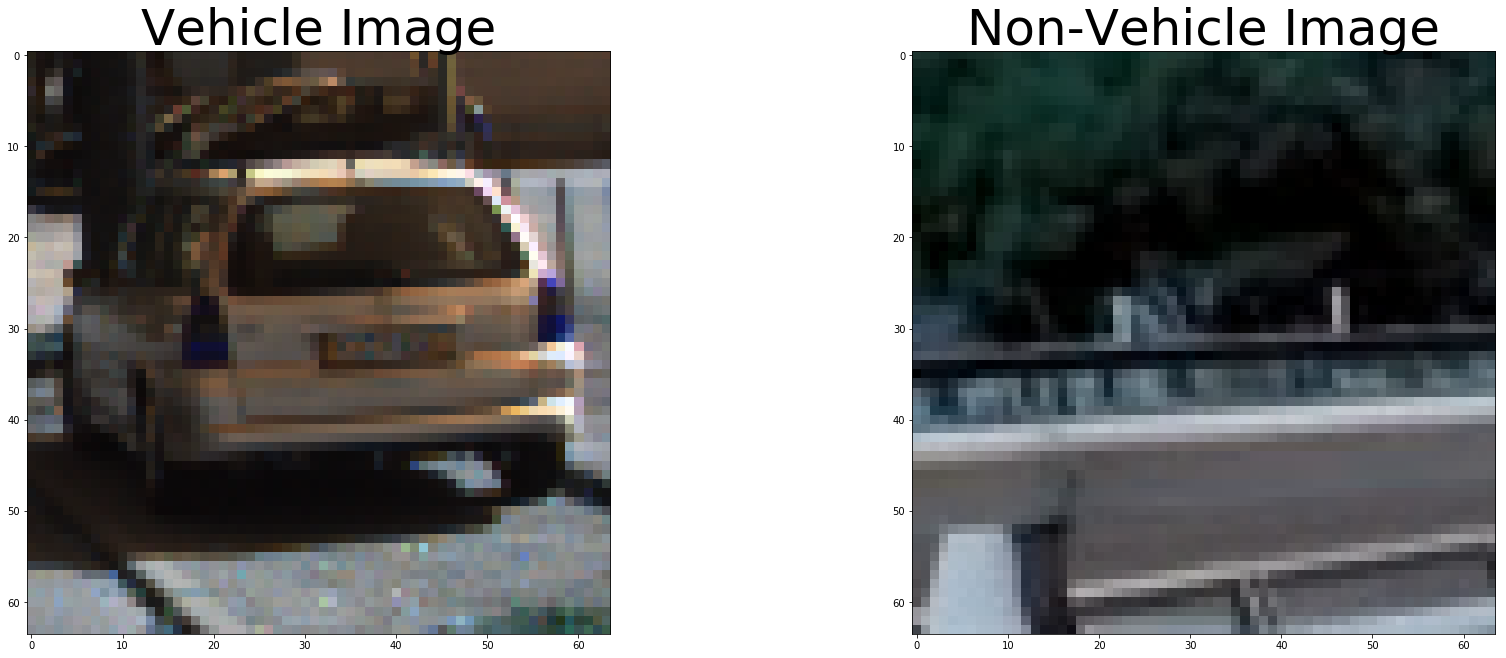

In [26]:
# show vehicle / non-vehicle images
data_set = '../data_base_png/*.png'
images = glob.glob(data_set)
cars = []
notcars = []
for image in images:
    if 'image' in image or 'extra' in image:
        notcars.append(image)
    else:
        cars.append(image)

print('notcars: ', len(notcars))
print('cars: ', len(cars))

index_nc = random.randint(0, len(notcars))
inde_c =  random.randint(0, len(cars))

image_nc = cv2.imread(notcars[index_nc])
image_c = cv2.imread(cars[inde_c])

   
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(image_c, cmap='gray')
ax1.set_title('Vehicle Image', fontsize=50)
ax2.imshow(image_nc, cmap='gray')
ax2.set_title('Non-Vehicle Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.) 

notcars:  8968
cars:  8792


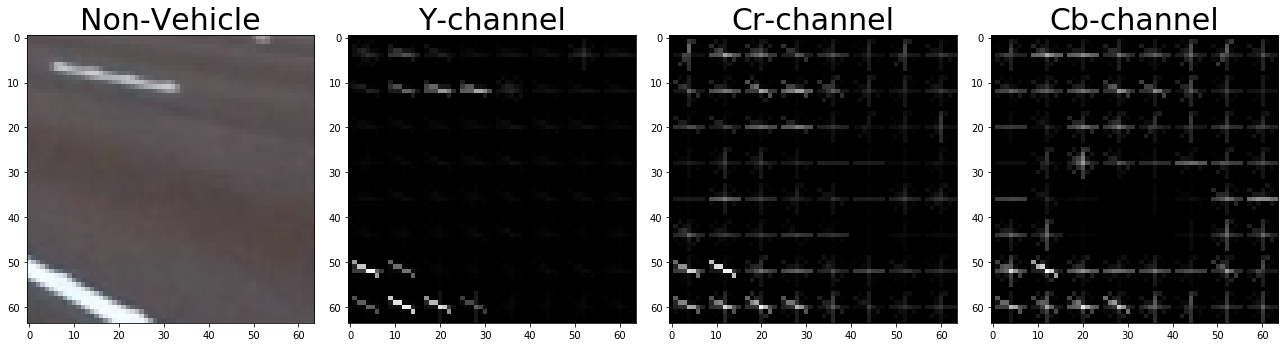

In [42]:
# show vehicle / non-vehicle images => HOG features
data_set = '../data_base_png/*.png'
images = glob.glob(data_set)
cars = []
notcars = []
for image in images:
    if 'image' in image or 'extra' in image:
        notcars.append(image)
    else:
        cars.append(image)

print('notcars: ', len(notcars))
print('cars: ', len(cars))

index_nc = random.randint(0, len(notcars))
inde_c =  random.randint(0, len(cars))

image_nc = cv2.imread(notcars[index_nc])
image_c = cv2.imread(cars[inde_c])

color_space = 'YCrCb'
orient = 18 # HOG orientations
pix_per_cell = 8 # HOG pixels per cell
cell_per_block = 2 # HOG cells per block
hog_calc = "skimage" #  "skimage" or "opencv"
 

draw_img = np.copy(image_nc)

draw_img = convert_color(draw_img, conv='RGB2YCrCb')   
ch1 = draw_img[:,:,0]
ch2 = draw_img[:,:,1]
ch3 = draw_img[:,:,2]
# Compute individual channel HOG features for the entire image
hog1, hog1_img = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, hog_calc, vis=True,feature_vec=False)
hog2, hog2_img = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, hog_calc, vis=True,feature_vec=False)
hog3, hog3_img = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, hog_calc, vis=True,feature_vec=False)

fig, ax = plt.subplots(1,4, sharex=True, figsize=(18,18))
plt.subplot(1,4,1) 
plt.imshow(image_nc)
plot_title = ('Non-Vehicle')
plt.title(plot_title, fontsize=30 )
plt.subplot(1,4,2) 
plt.imshow(hog1_img, cmap='gray')
plot_title = ('Y-channel')
plt.title(plot_title, fontsize=30 )
plt.subplot(1,4,3) 
plt.imshow(hog2_img, cmap='gray')
plot_title = ('Cr-channel')
plt.title(plot_title, fontsize=30 )
plt.subplot(1,4,4) 
plt.imshow(hog3_img, cmap='gray')
plot_title = ('Cb-channel')
plt.title(plot_title, fontsize=30 )
    
plt.tight_layout()   
plt.show()


 save file:  SVC_trained/LinearSVC_20170421_173733.p 
 color_space:  YCrCb orient:  18 pix_per_cell:  8 cell_per_block:  2 hog_channel:  ALL hog_calc : skimage 
 spatial_size:  (4, 4) hist_bins:  256 clf_svc.cell_per_win:  8 
data_set:  data_base_png/*.png


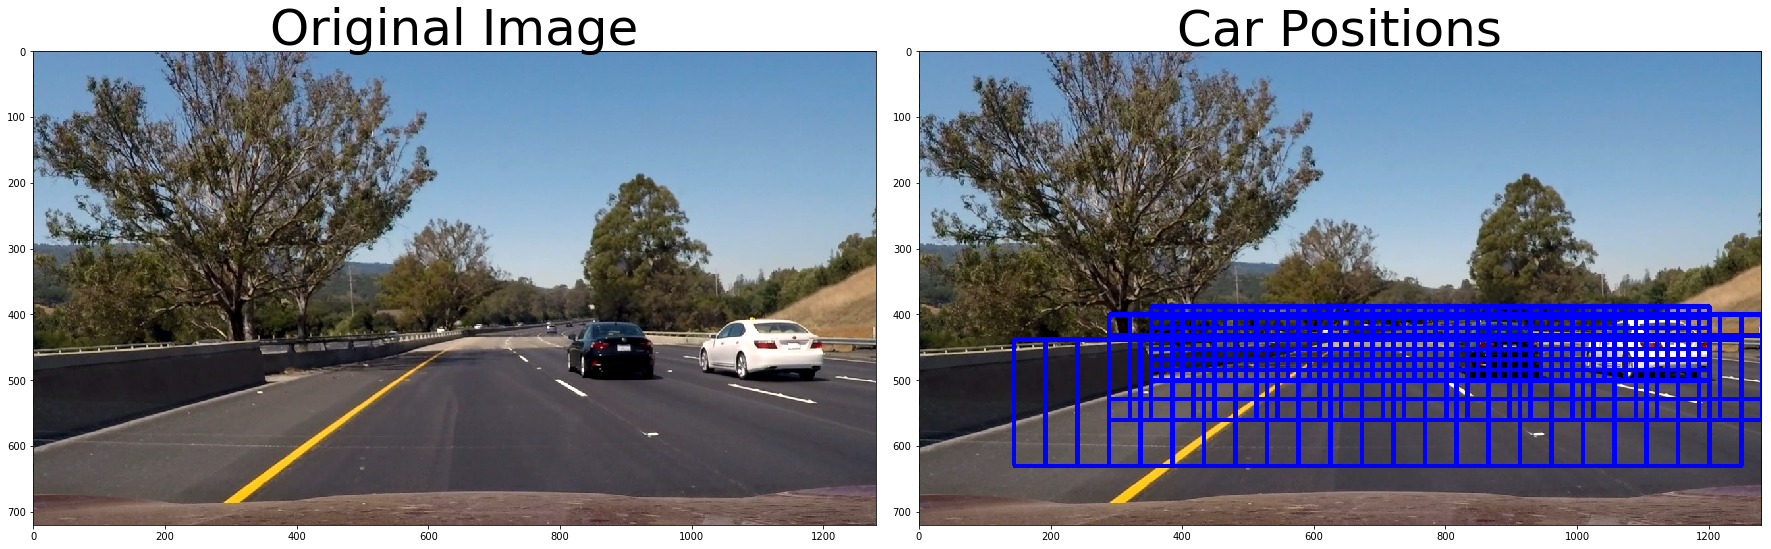

In [32]:
# check window position and vehicle detection

windows_check = False
if windows_check:

    pickle_name= "SVC_trained/LinearSVC_20170421_173733.p"
    dist_pickle = pickle.load( open(pickle_name, "rb" ) )
    svc = dist_pickle["svc"]
    X_scaler = dist_pickle["scaler"]
    classifier_ = dist_pickle["clf_name"]
    color_space = dist_pickle["color_space"]
    orient = dist_pickle["orient"]
    pix_per_cell = dist_pickle["pix_per_cell"]
    cell_per_block = dist_pickle["cell_per_block"]
    hog_channel = dist_pickle["hog_channel"]
    hog_calc = dist_pickle["hog_calc"]
    spatial_size = dist_pickle["spatial_size"]
    hist_bins = dist_pickle["hist_bins"]
    cell_per_win = dist_pickle["cell_per_win"]
    data_set = dist_pickle["data_set"]
        
    print('\n save file: ', pickle_name, '\n color_space: ', color_space, 'orient: ', orient, \
          'pix_per_cell: ', pix_per_cell,'cell_per_block: ', cell_per_block, \
          'hog_channel: ', hog_channel,'hog_calc :', hog_calc, '\n spatial_size: ', spatial_size,\
          'hist_bins: ', hist_bins, 'clf_svc.cell_per_win: ',cell_per_win,'\ndata_set: ', data_set)

    
    #img = mpimg.imread('bbox-example-image.jpg')
    img = mpimg.imread('test_images/test6.jpg')
    #img = mpimg.imread('test_img.jpg')

    draw_img = np.copy(img)
    car_boxes_raw = mul_win_slide(draw_img,svc, X_scaler, orient, pix_per_cell,\
                                  cell_per_block, spatial_size, hist_bins, cell_per_win, hog_calc)
    
    for i in range(len(car_boxes_raw)):#[:,0])):
        cv2.rectangle(draw_img,(car_boxes_raw[i,0],car_boxes_raw[i,1]),(car_boxes_raw[i,2],car_boxes_raw[i,3]),(0,0,255),6) 

   
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
    f.tight_layout()
    ax1.imshow(img, cmap='gray')
    ax1.set_title('Original Image', fontsize=50)
    ax2.imshow(draw_img, cmap='gray')
    ax2.set_title('Car Positions', fontsize=50)
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.) 
        
        
    plt.imshow(draw_img)

In [ ]:
def debug_frame(ori_img, main_img, p_win, p_heat, car_boxes_raw, heatmap):

    shape = main_img.shape[0:2]
    demi_shape = (shape[0] // 2, shape[1] // 2)
    re_shape = (int(shape[0] * 1.5), int(shape[1] * 1.5), 3)
    draw_img = np.zeros(re_shape, dtype=main_img.dtype)

    # Main image
    draw_img[:shape[0], :shape[1]] = main_img

    # 2 horizontal windows
#    m = 2
#    offset = 0
#    img_titles = ['previous all windows',
#              'previous heatmap']
#    for i in range(m):
#        if i == 0:
#            temp_img = np.copy(p_win)
#            cv2.putText(temp_img, img_titles[i], (50, 70), cv2.FONT_HERSHEY_DUPLEX, 1.3, (255, 255, 255), 2)
#            draw_img[shape[0]:, offset:offset+shape[1]//2] = cv2.resize(temp_img, demi_shape[::-1])
#        else:
#            temp_img = np.copy(p_heat)
#            out_img = np.stack((temp_img, np.zeros_like(temp_img).astype(np.uint8), np.zeros_like(temp_img).astype(np.uint8)),axis=2)
#            out_img = out_img*255./(np.max(temp_img))
#            cv2.putText(out_img, img_titles[i], (50, 70), cv2.FONT_HERSHEY_DUPLEX, 1.3, (255, 255, 255), 2)
#            draw_img[shape[0]:, offset:offset+shape[1]//2] = cv2.resize(out_img, demi_shape[::-1])
#        offset += demi_shape[1]

    # 2 horizontal windows
    m = 2
    offset = 0
    img_titles = ['heat combined',
              'heat combined raw']
    for i in range(m):
        if i == 0:
            temp_img = np.copy(p_win)
            out_img = temp_img*255./(np.amax(temp_img))
            out_img = np.reshape(out_img, out_img.shape + (1,))
            out_img = np.concatenate([np.ones_like(out_img),
                                      np.zeros_like(out_img),
                                      out_img], axis=2)
            out_img = out_img.astype(np.uint8)
            cv2.putText(out_img, img_titles[i], (50, 70), cv2.FONT_HERSHEY_DUPLEX, 1.3, (255, 255, 255), 2)
            draw_img[shape[0]:, offset:offset+shape[1]//2] = cv2.resize(out_img, demi_shape[::-1])
        else:
            temp_img = np.copy(p_heat)
            temp_img = np.reshape(temp_img, temp_img.shape + (1,))
            h1= np.copy(temp_img)
            h2= np.copy(temp_img)
            h3= np.copy(temp_img)
            
            h1[(temp_img[:,:,0] < 6) & (temp_img[:,:,0] > 0)]=255
            h2[(temp_img[:,:,0] >= 12)]=255
            h3[(temp_img[:,:,0] < 12) & (temp_img[:,:,0] >= 6)]=255
                       
            out_img = np.concatenate([h1, h2, h3],axis=2)
            out_img = out_img.astype(np.uint8)                                   
#            out_img = out_img*255./(np.max(temp_img))
            cv2.putText(out_img, img_titles[i], (50, 70), cv2.FONT_HERSHEY_DUPLEX, 1.3, (255, 255, 255), 2)
            draw_img[shape[0]:, offset:offset+shape[1]//2] = cv2.resize(out_img, demi_shape[::-1])
        offset += demi_shape[1]
        
    # 3 vertical windows
    k = 3
    offset = 0
    img_titles = ['All detected windows',
              'Heatmap',
              'non-max suppresion']
    for i in range(k):
        if i == 0:
            box_img = np.copy(ori_img)
            for n in range(len(car_boxes_raw)):
                cv2.rectangle(box_img,(car_boxes_raw[n,0],car_boxes_raw[n,1]),(car_boxes_raw[n,2],car_boxes_raw[n,3]),(0,0,255),6) 
            cv2.putText(box_img, img_titles[i], (50, 70), cv2.FONT_HERSHEY_DUPLEX, 1.3, (255, 255, 255), 2)
            draw_img[offset:offset+shape[0]//2:, shape[1]:] = cv2.resize(box_img, demi_shape[::-1])
        elif i ==1:
            temp_img = np.copy(heatmap)
            out_img = temp_img*255./(np.amax(temp_img))
            out_img = np.reshape(out_img, out_img.shape + (1,))
            out_img = np.concatenate([np.ones_like(out_img),
                                      np.zeros_like(out_img),
                                      out_img], axis=2)
            out_img = out_img.astype(np.uint8)
            cv2.putText(out_img, img_titles[i], (50, 70), cv2.FONT_HERSHEY_DUPLEX, 1.3, (255, 255, 255), 2)
            draw_img[offset:offset+shape[0]//2:, shape[1]:] = cv2.resize(out_img, demi_shape[::-1])
        else:           
            # non-maximum suppression
            draw_img_nms = np.copy(ori_img)
            #bboxes_raw = []
            bboxes_fin = non_max_suppression_fast(car_boxes_raw, 0.5)
            if bboxes_fin == []:
                draw_img_nms = np.copy(main_img)
            else:
                for p in range(bboxes_fin.shape[0]):
                    cv2.rectangle(draw_img_nms,(bboxes_fin[p,0],bboxes_fin[p,1]),(bboxes_fin[p,2],bboxes_fin[p,3]),(0,255,0),6)             
            cv2.putText(draw_img_nms, img_titles[i], (50, 70), cv2.FONT_HERSHEY_DUPLEX, 1.3, (255, 255, 255), 2)
            draw_img[offset:offset+shape[0]//2:, shape[1]:] = cv2.resize(draw_img_nms, demi_shape[::-1])

        # Add text...
        offset += demi_shape[0]
        
    return draw_img
